

# CSCI250 Python Computing: Building a Sensor System
## Capstone final report


# Title : Biomechanic Analysis of Climbers During Bouldering

<img src="https://i.imgur.com/CQUPV5f.jpeg" width="40%" >
<img src="https://i.imgur.com/JbLzBUm.jpeg" width="40%" >
<img src="https://i.imgur.com/CWOqAhN.jpeg" width="40%" >


# Group 

List all members and indicate specific project responsibilities:

* Tobin Ford, software, hardware, climbing, data analysis
* Alexander Capehart, software, sensor classes, climbing, data analysis

# Description

Our project a sensor system that can be attached to a climber to record biokinematic data during climbing. The sensor array consited of 5 accelerometers, 2 pressure sensitive resistors and 2 flex sensitive resistors. We preformed numerical integration to calculate velocity and position from acceleration. We also used numerical differentiation to calculate jerk (the derivative of acceleration with respect to time). We preformed various analysis on this data including calculating an efficiency metric to compare the relative efficiencies of climbing moves. We only used the relative voltage of the flex and pressure resistors rather than calculating resistance. This was fine for our purposes because the voltage is linear just like resistance.

# Hardware

- 5x Accelerometers
- 1x Qwiic Mux (To combine Accelerometers)
- 2x Pressure Sensors
- 2x Flex sensors

# Operation

- Attach Accelerometers to Mux, make sure to daisy chain jumpers so they span across all limbs
- Attach sensor system to climber, connect to RPi
- Run "data collection" part of this notebook when the climber starts climbing
- Specify the files to read in the "data analysis" part of this notebook

# Data

As stated in the capstone guidelines notebook, your project must have 4 data components:

1. **Collect** data
2. **Process** data
3. **Display** data
4. **Interpret** data

Include a description of the data you collected, what processing you did, graphs/plots/visuals created by your code, and your interpretation/analysis of the data. 

There is no need to include raw data unless it helps your explanation.

**Data collected:**
- Acceleration from all 4 limbs and center of mass
- Pressure from soles of feet
- Flex of knees

**Data processed:**
- Acceleration smoothed out with outliers removed
- Numeric integration and derivation performed on acceleration to determine jerk, velocity, position
- Flex sensor and pressure sensor data cleaned to remove floating/indeterminant values

**Data displayed:**
- Center of mass smoothed acceleration, veloicty, position over time
- Animated "Person" diagram using position data from acceleromers
- Movement efficiency metrics
- Magnitude of arm jerk

# Wiring

<img src="https://i.imgur.com/jOCRNjO.png" width="40%" >  

We used a voltage divider for each flex and pressure sensitive resistors. Each of the 5 accelerometers were hooked up to the mux which was then connected to the breadboard with the GPIO on it. Each accelerometer and the main I2C connection on the multiplexor used the following cables all the same (blue = sda, yellow = scl, red = vcc, black = gnd). These cables were also connected to their matching pins on the gpio (same name color mapping)


# Code

## External Dependencies
Qwiic I2C Library: https://qwiic-i2c-py.readthedocs.io/en/latest/index.html

Qwiic tca9548a (Qwiic Mux) Library: https://qwiic-i2c-py.readthedocs.io/en/latest/index.html

### Data Collection

This code collects all of the information required from the sensor system over a 60 second period, assuming it's setup up to the right ports and attached to the climber. 

In [7]:
# imports
import time
import qwiic_i2c
import qwiic_tca9548a
import accUtil as acc
import adcUtil as adc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML

In [ ]:
ACCELEROMETERS_OUT_FILE = "accelerometers5.npy"
FLEX_SENSORS_OUT_FILE = "flexSensors5.npy"
PRESSURE_SENSORS_OUT_FILE = "pressureSensors5.npy"

In [29]:
class Accelerometers():
    def __init__(self, n = 5):
        self.n = n
        # cols = time + accelerometer amount * 3 coordinates
        self.data = np.zeros( [ 0, 1 + self.n * 3 ]) 
        self.calibration = np.zeros(1 + self.n * 3)
        self.mux = qwiic_tca9548a.QwiicTCA9548A(address=0x70, i2c_driver=qwiic_i2c.getI2CDriver())
        self.tref = 0
        self.absolute = np.zeros(1 + self.n * 3)
       
    def calibrate(self, tref, absolute = np.array([ 0, 0, 9.81 ])):
        self.tref = tref
        # Our accelerometers will not be in their norma position when recording and will produce odd results.
        # We mitigate this by measuring relative acceleration by comparing all subsequent readings to the first
        # one we get here. Then we turn relative back into absolute acceleration by pegging it to a pre-defined
        # vector like <0, 0, 9.81> (i.e completely still).
        self.absolute = np.pad(np.tile(absolute, self.n), (1, 0), constant_values=(0))
        self.__read(self.calibration)

    def table(self):
        return pd.DataFrame(data=self.data)
        
    def record(self):
        # Add a new row (append wont work)
        self.data.resize((len(self.data) + 1, 1 + self.n * 3))
        # Add record time
        self.data[-1][0] = time.time() - self.tref
        # Record data
        self.__read(self.data[-1])
        # Calibrate the data
        self.data[-1] = self.data[-1] - self.calibration + self.absolute
        
    def __read(self, row):
        # All accelerometers in the mux go through the same I2C address, we just change the mux to change which one
        # we operate on that I2C address. Go through each accelerometer channel and record all the data we can from
        # it.
        for i in range(self.n):
            self.mux.disable_all()
            self.mux.enable_channels([i])
            x, y, z = acc.readACC(model="MMA8452Q")
            row[i * 3 + 1] = x
            row[i * 3 + 2] = y
            row[i * 3 + 3] = z
        return row
    
    def save(self, filename="accelerometers.npy"):
         np.save(filename, self.data)

In [ ]:
class ResistanceSensors():
    def __init__(self, dev, n = 2):
        self.dev = dev
        self.n = n
        self.tref = 0
        self.data = np.zeros( [ 0, 1 + self.n ], dtype=float) # cols = time + accelerometer amount
    
    def calibrate(self, tref):
        self.tref = tref
        
    def table(self):
        return pd.DataFrame(data=self.data)
        
    def record(self):
        # Add a new row (append wont work)
        self.data.resize((len(self.data) + 1, 1 + self.n))
        row = self.data[-1]
        # Add record time
        row[0] = time.time() - self.tref
        for i in range(self.n):
            vou = adc.readADC(channel=i, device=self.dev)
            # Don't need resistance since we are mostly need relative rather than absolute data 
            row[i + 1] = vou
    
    def save(self, filename):
         np.save(filename, self.data)

In [ ]:
# Initialize sensors
accs = Accelerometers()
pressureSensors = ResistanceSensors(0)
flexSensors = ResistanceSensors(1)

# Calibrate them to start time
tref = time.time()
flexSensors.calibrate(tref)
pressureSensors.calibrate(tref)
accs.calibrate(tref)

# Collect as much as we can for 60 seconds
while time.time() - tref < 60:
    accs.record()
    pressureSensors.record()
    flexSensors.record()

# Save (this will overwrite old data, be careful)
flexSensors.save(FLEX_SENSORS_OUT_FILE)
pressureSensors.save(PRESSURE_SENSORS_OUT_FILE)
accs.save(ACCELEROMETERS_OUT_FILE)

### Acceleration Processing

This code smooths out the acceleration data to eliminate natural error/wobble from the recorded data, and then does windowed numerical integration in order to approximate the relative position each accelerometer was likely at.

In [30]:
ACCELEROMETERS_IN_FILE = "accelerometers.npy"
FLEX_SENSORS_IN_FILE = "flexSensors.npy"
PRESSURE_SENSORS_IN_FILE = "pressureSensors.npy"

In [31]:
raw_accs = np.load(ACCELEROMETERS_IN_FILE)
adj = np.pad(np.tile([0, 0, -9.81], 5), (1, 0), constant_values=(0))
raw_accs += adj
WINDOW_SIZE = 128

# Adapt smoothing code from SL3 simply because it's easier to adapt to our matrix format which has a time column.
smoothed_accs = np.empty(raw_accs.shape, dtype=float)
smoothed_accs[:, 0] = raw_accs[:, 0]
for i in range(len(raw_accs)):
    if i < WINDOW_SIZE // 2:
        # Window isn't complete yet, just take the latter half and whatever
        # comes in the beginning
        right = i + WINDOW_SIZE // 2
        window = raw_accs[:right, 1:]
    elif i + WINDOW_SIZE // 2 >= len(raw_accs):
        left = i - WINDOW_SIZE // 2
        # Can't form full window from remaining data, take whatever data we have
        # before up to the end of the data
        window = raw_accs[left:len(raw_accs), 1:]
    else:
        # Can form full window from both ends.
        left = i - WINDOW_SIZE // 2
        right = i + WINDOW_SIZE // 2
        window = raw_accs[left:right, 1:]
    smoothed_accs[i, 1:] = np.mean(window, axis=0)

# Adapt integration code from SL2 since normal trapezoidal integration will actually cause issues (see below)
def modified_trap_integral(arr):
    out = np.zeros(arr.shape, dtype=float)
    for i in range(1, len(arr)):
        # Sadly accelerometers are too inaccurate/wobbly to get perfect acceleration data from. Minor errors and acceleration
        # will accumulate during any kind of integration until our position values grow entirely inaccurate. Mitigate this by
        # taking a windowed integral only over the last 32 terms, which "resets" the error but also the position, to get
        # something that is at least won't unrealistically blow up. There are ways to get even better data from accelerometers
        # using gyroscopes and weird filters, but we did not have time for that.
        l = max(i - 32, 0)
        r = i
        a = arr[l][0]
        b = arr[r][0]
        n = r - l
        c = (b - a) / (2 * n)
        sli = arr[l:r, 1:]
        f0 = sli[0, :]
        # From 1 to n - 1 maps to from 1 to n - 2 in zero-indexed notation
        sigma = np.sum(sli[1:n - 2, :] * 2, axis=0)
        # f_n maps to f[n - 1] in zero-indexed notation.
        fn = sli[n -  1, :]
        out[i][0] = arr[i][0]
        out[i, 1:] = c * (f0 + sigma + fn)
    return out

# Integrate to find approximate velocity and position
vel = modified_trap_integral(smoothed_accs)
pos = modified_trap_integral(vel)

### Acceleration Display

This code displays graphs for the center of mass raw/smoothed acceleration, velocity, position in order to demonstrate the recorded data and it's processing.

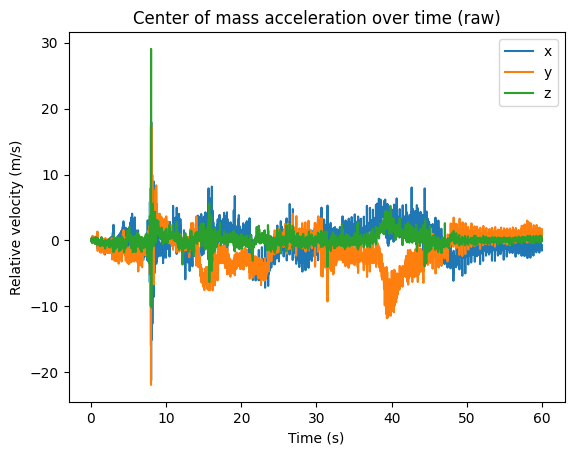

In [32]:
plt.plot(raw_accs[:,0], raw_accs[:, 1:4])
plt.title("Center of mass acceleration over time (raw)")
plt.xlabel("Time (s)")
plt.ylabel("Relative velocity (m/s)")
plt.legend(["x","y","z"])

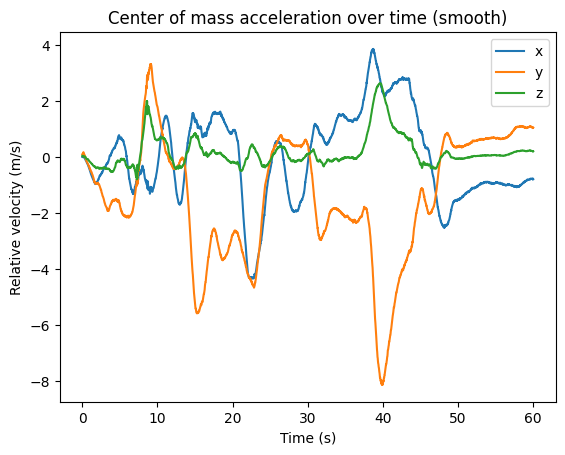

In [33]:
plt.plot(smoothed_accs[:,0], smoothed_accs[:, 1:4])
plt.title("Center of mass acceleration over time (smooth)")
plt.xlabel("Time (s)")
plt.ylabel("Relative velocity (m/s)")
plt.legend(["x","y","z"])

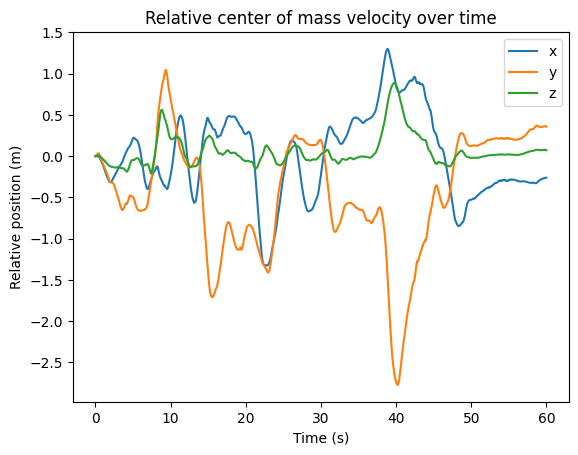

In [34]:
plt.plot(vel[:,0], vel[:, 1:4])
plt.title("Relative center of mass velocity over time")
plt.xlabel("Time (s)")
plt.ylabel("Relative position (m)")
plt.legend(["x","y","z"])

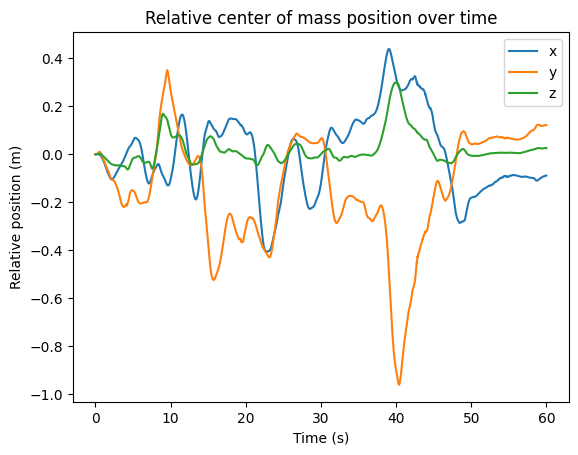

In [35]:
plt.plot(pos[:,0], pos[:, 1:4])
plt.title("Relative center of mass position over time")
plt.xlabel("Time (s)")
plt.ylabel("Relative position (m)")
plt.legend(["x","y","z"])

### Person Diagram

This code processes and displays an general approximation of the relative position of the climber's limbs/center of mass based on the integrated smoothed accelerometer data. Each limb is represented by a outlined (no pressure) or filled (pressure) square that is either dark blue if close to the viewer or light blue if further away to indicate movement along the z axis.

In [36]:
pressure = np.load("pressureSensors2.npy")

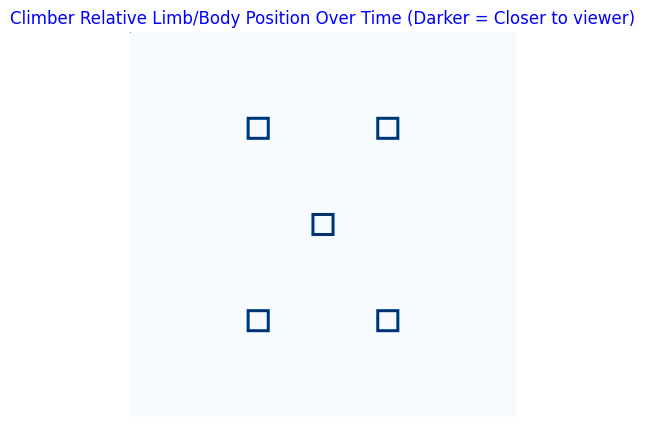

In [40]:
n = 500
nR = n
nC = n
nT = 250

MOVIE = np.zeros( [nR,nC,nT], dtype=float)
MOVIE[0][0][0] = 1 # Work around animation bug

# Relative dimensions we use to arrange limbs/center of mass
MID_ADJ = n // 2
INNER_ADJ = n // 3
OUTER_ADJ = n // 4

LIMB_SIZE = n // 32
# Make pre-made hole to draw for unfilled accelerometers
HOLE = np.zeros([LIMB_SIZE * 2, LIMB_SIZE * 2])
HOLE[:,:] = 1
HOLE[4:-4, 4:-4] = 0

def coord(c, s):
    # Adjust position to a 100 px range (assuming it's most likely between 0m and 1m)
    adj = int(c * 100)
    # Clamp to 100px (Usually 100px is never exceeded)
    if adj > 100:
        adj = 100
    elif adj < -100:
        adj = -100
    # Convert relative position to absolute given initial position
    return adj + s

def draw(t, start, sx, sy, sz, filled):
    ax = pos[t][start]
    ay = pos[t][start+1]
    az = pos[t][start+2]
    # Two assumptions are made here:
    # 1. We assume that the accelerometers axis is like this conventional diagram:
    #   z
    #   |
    #   .--y
    #  /
    # x
    # 2. And we assume that the rock wall is oriented on the yz-plane. (This is a guess I made based
    # on how accurate it seemed)
    # These assumptions make us rotate the coordinates into this diagram:
    #   y
    #   |
    #   .--x
    #  /
    # z
    # Which we use from here on for readability.
    px = coord(ay, sx)
    py = coord(az, sy)
    pz = coord(ax, 0)
    darkness = (1 + pz/100) + 0.1 # Higher z -> Closer to viewer -> Darker
    if filled:
        # Filled, fully draw. Note that we add to avoid limbs from overwriting eachother if they overlap
        # (which happens later in the data when error piles up and results in more inaccurate positions)
        MOVIE[py - LIMB_SIZE:py + LIMB_SIZE, px - LIMB_SIZE:px + LIMB_SIZE, i] += darkness
    else:
        # Not fileld, draw outline
        MOVIE[py - LIMB_SIZE:py + LIMB_SIZE, px - LIMB_SIZE:px + LIMB_SIZE, i] += HOLE * darkness

for i in range(nT):
    # We have so many data samples that loading them all into the movie would take too long, just pick random
    # samples across the runtime of the movie instead.
    t = int((i/nT)*len(pos))
    # Draw limbs/center of mass onto this movie frame
    draw(t, 1, MID_ADJ, MID_ADJ, 0, False)
    # Legs, fill in if pressure was high enough to imply that the climber was stepping down
    draw(t, 4, nC - INNER_ADJ, nR - OUTER_ADJ, 0, pressure[t][1] > 3.0)
    draw(t, 7, INNER_ADJ, nR - OUTER_ADJ, 0, pressure[t][2] > 3.0)
    draw(t, 10, INNER_ADJ, OUTER_ADJ, 0, False)
    draw(t, 13, nC - INNER_ADJ, OUTER_ADJ, 100, False)

# Show animated movie
climbFig = plt.figure(figsize=(10,5))

climbPlotA = plt.imshow(MOVIE[:,:,0], cmap="Blues") # first frame of AMOVIE 
plt.title("Climber Relative Limb/Body Position Over Time (Darker = Closer to viewer)",color='blue')
plt.axis('off');

def climbAnimate(i, MA, PA):
    PA.set_data( MA[:,:,i] )
    plt.axis('off')

# Create inline animation
climbMovieA = ani.FuncAnimation(fig   = climbFig, 
                            func   = climbAnimate, 
                            frames = nT,
                            fargs  = (MOVIE,climbPlotA)
                            );

HTML(climbMovieA.to_html5_video())

Text(0.5, 1.0, 'Flex Data')

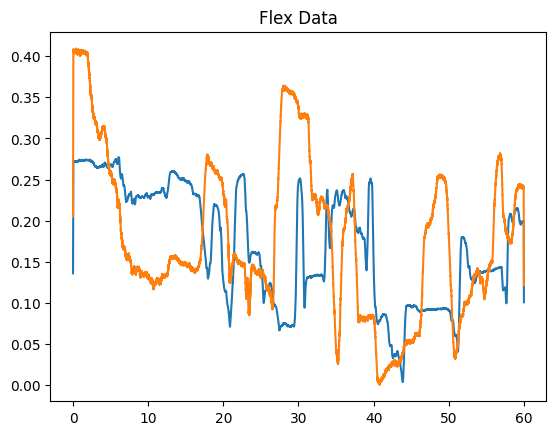

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

flex_path = 'flexSensors4.npy'
pressure_path = 'pressureSensors2.npy'
accelerometers_path = 'accelerometers.npy'
flex_null_path = 'flexSensors_baseline.npy'
flex_full_path = 'flexSensors_full_bend.npy'

acclData = np.load(accelerometers_path)
flexData = np.load(flex_path)
flexNull = np.load(flex_null_path)
flexFull = np.load(flex_full_path)
presData = np.load(pressure_path)

# peg minimum value of flex data to 0, could smooth the data firsts to avoid the manual shift
normalized_0 = np.subtract(flexData[:,1], np.min(flexData[:,1]))
normalized_1 = np.subtract(flexData[:,2], np.min(flexData[:,2]))
normalized_1 = np.subtract(normalized_1, 0.05) # manual shift, ideally wouldn't have to do this but theres some weird minimum value messing up our shift

def convolve_smooth(
    arr : np.ndarray, 
    window_size : int = 128,
    )-> np.ndarray:

    kernel = np.ones(window_size) / window_size
    res = np.convolve(arr, kernel, mode='same')
    return res

# smooth data after peg minimum value to 0
smoothe_0 = convolve_smooth(normalized_0)
smoothe_1 = convolve_smooth(normalized_1)

# plot
plt.plot(flexData[:,0], smoothe_0)
plt.plot(flexData[:,0], smoothe_1)
plt.title("Flex Data")

## Simple Framework for Analyzing Efficiency of a Discrete Move
Generally, climbing moves become more efficient as more weight is placed on the feet (reducing the load on the upper body) and as the arms become straighter (transfering load from soft tissue including muscle and tendons to the skeleton). If we can quantify the area under the curve for elbow flex and pressure on the feet we can come up with a unitless number to represent the "efficiency" of a move on a scale from 0 to 1. Where 0 would represent arms fully bent with no weight on the feet and 1 represents the entire body weight on the feet and straight arms. This is a gross oversimplification as it ignores many factors including but not limited to shoulder engagement, body position, knee flexion, and many many others. Perhaps most importantly we are capturing arm bend even when the limb is not contancting the wall this gives us information that we don't care about. Arm bend does not matter if no contact is occuring. This could be resolved via finger pressure sensors. Even with these shortcomings, we have a potentially viable framework for analyzing *very basic* climbing moves.

### Important TimeSteps in Video
- Establish (all points on wall) : $t=13s$
- First left hand move end : $t=14s$
- First right foot move end : $t=17s$
- First right hand move end : $t=18s$
- Second left hand move end : $t=20s$
- sequence of foot moves (right foot up, match left foot, right foot up) end : $t=23s$
- left hand move, right hand match on finish end : $t=27s$

We can look at slices between these moves to calculate our "efficiency". The most interesting moves for this type of analysis are given in the last 2 bullet points above.

Text(0.5, 1.0, 'Pressure Data')

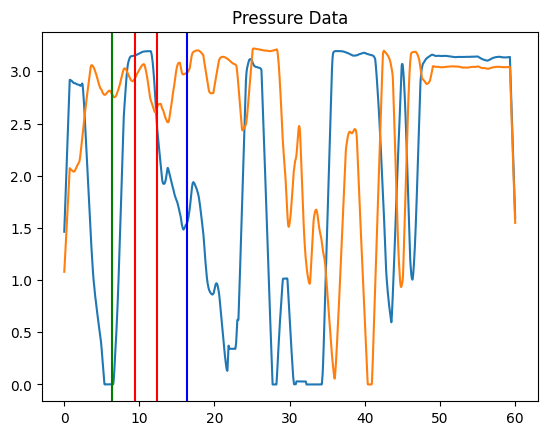

In [9]:
plt.plot(acclData[:,0], convolve_smooth(presData[:,1]))
plt.plot(acclData[:,0], convolve_smooth(presData[:,2]))
plt.axvline(6.4, color='g') # t = 17s
plt.axvline(9.4, color='r') # t = 20s (start of sequence of foot moves)
plt.axvline(12.4, color='r') # t = 23s (end of sequence of foot moves), start of finish match
plt.axvline(16.4, color='b') # t = 27s (end of sequence of foot moves), start of finish match
plt.title('Pressure Data')

### Breakdown:
In the plot above the data between the red bars represent a sqeuence of fast foot moves that take place from 20 - 23 seconds in the video. And the data between the 2nd red bar and the blue bar represent the finish match which takes place from 23-27 seconds in the video (finishing the boulder.) We are not really interested in any of the data after this time because it is not representative of normal climbing, rather Tobin down climbed to avoid breaking the sensors instead of jumping down as normal.

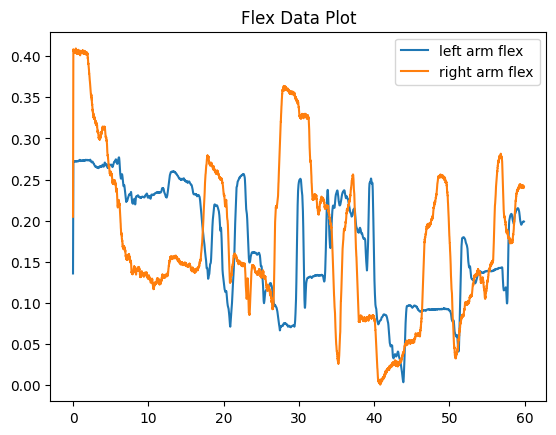

In [10]:
smooth_flex_0 = convolve_smooth(flexData[:,1])
smooth_flex_1 = convolve_smooth(flexData[:,2])

# downsample and clip
sub_time = flexData[:,0][::20][:acclData.shape[0]:]
# downsample
sub_smooth_flex_0 = smoothe_0[::20]
sub_smooth_flex_1 = smoothe_1[::20]

# clip
sub_smooth_flex_0 = sub_smooth_flex_0[:acclData.shape[0]:]
sub_smooth_flex_1 = sub_smooth_flex_1[:acclData.shape[0]:]

#updating flex data array
flexData = np.column_stack((sub_time, sub_smooth_flex_0, sub_smooth_flex_1))

plt.plot(sub_time, sub_smooth_flex_0, label='left arm flex')
plt.plot(sub_time, sub_smooth_flex_1, label='right arm flex')
plt.title('Flex Data Plot')
plt.legend()

In [11]:
# returns index of closest value in array
def find_nearest(array, value):
    # calculate differences
    difference_array = np.absolute(array - value)
    # find minimum value in array (smallest will be closest to target value)
    index = difference_array.argmin()
    return index

# calculate efficiency
def efficiency(
    start_time, 
    end_time, 
    flex, 
    pressure
    ):
    
    # period length to normalize for sample length
    period = end_time - start_time

    # calculate index bounds
    flex_start = find_nearest(flex[:,0], start_time)
    flex_end = find_nearest(flex[:,0], end_time)
    pressure_start = find_nearest(pressure[:,0], start_time)
    pressure_end = find_nearest(pressure[:,0], end_time)

    # calculate areas under the curve
    flex_area_1 = np.trapz(flex[flex_start:flex_end, 1], x=flex[flex_start:flex_end, 0])
    flex_area_2 = np.trapz(flex[flex_start:flex_end, 2], x=flex[flex_start:flex_end, 0])
    pressure_area_1 = np.trapz(pressure[pressure_start:pressure_end, 1], x=pressure[pressure_start:pressure_end, 0])
    pressure_area_2 = np.trapz(pressure[pressure_start:pressure_end, 2], x=pressure[pressure_start:pressure_end, 0])

    # calculate averages
    flex_area = (flex_area_1 + flex_area_2) / 2
    pressure_area = (pressure_area_1 + pressure_area_2) / 2

    # calculate efficiency
    # Weights: 30% flex, 70% pressure
    flex_weight, pressure_weight = 0.3, 0.7

    # calculate weighted areas
    flex_area_weighted = flex_weight * flex_area
    pressure_area_weighted = pressure_weight * pressure_area

    # calculate combined area
    combined_area = flex_area_weighted + pressure_area_weighted

    # normalize area
    # find maximum value in the data from both arrays
    data_max = max(np.max(flex[:,1:]), np.max(pressure[:,1:]))

    # calculate normalized efficiency value
    normal_efficiency = (combined_area / data_max) / period

    # area under the curve for each
    return normal_efficiency 

In [12]:
# calculate efficincy of sequence of foot moves
foot_moves_efficiency = efficiency(
    start_time=9.4,
    end_time=12.4,
    flex=flexData,
    pressure=presData
)

# calculate efficiency of finish move
finish_move_efficiency = efficiency(
    start_time=12.4,
    end_time=16.4,
    flex=flexData,
    pressure=presData
)

print(f"foot sequence : {foot_moves_efficiency}")
print(f"finish sequence : {finish_move_efficiency}")

foot sequence : 0.6669520017366263
finish sequence : 0.5123785647099138


## Effciency Analysis Conclusion

Here we can see that the foot moves are "more efficient".  

The accuracy of this is questionable because of following errors during the measurement process. The pressure sensors we used were intended for much lighter weights (at around 10 lbs instead of my entire bodyweight). The duct tape holding the pressure sensors onto my feet was flimsy and the pressure sensors were not in the exact same places. Additionally, the flex sensors were held onto the inside of my elbows using duct tape. While this was workable and much better reliability wise than having the flex sensors on the outside of the elbow. However, this did not eliminate all of the issues. Because we used tape to hold the flex sensors on, the tape loosed as time went on and I climbed. This resulted in the flex sensor bending inconsistently based on elbow flexion due to the tape becoming loose and the flex sensor pushing into it rather than bending. With a more appropriate and flexible flex sensor, this could be come more reliable

## Jerk Analysis

Jerk is the derivative of acceleration (change in acceleration with respect to time). This could add another tool to our ability to determine movement efficiency. Less jerk means more efficient movement because the body has to put in less effort to adjust to changes in acceleration or jerk. Jerk can be conceptualized as smoothness of movement. https://www.frontiersin.org/articles/10.3389/fbioe.2021.782740/full. Because of this jerk is also associated with risk of injury. Less smooth or rougher movements will lead to a higher risk of injury. See the magnitude of the jerk in the left and right hands in the graph below. This would be useful as a comparison tool between different moves, sequences of moves, or different climbers. See the trivial example below

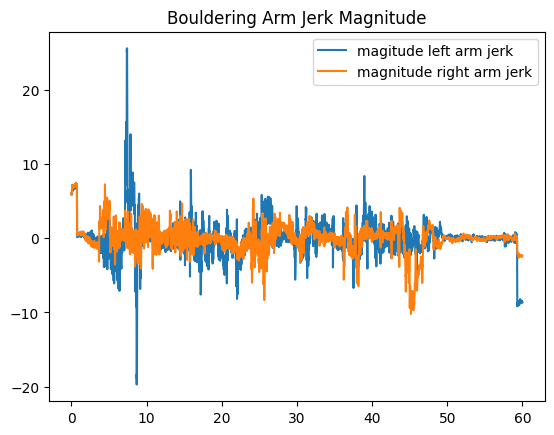

In [13]:
# accelerometer 0 was com, accelerometer left was 1, accelerometer was 2
# time will be 0
# COM accel 0 will be 1, 2, 3
# LARM accel 1 will be 4, 5, 6
# RARM accel 2 will be 7, 8, 9

# calculate magnitude of acceleration for each arm
acc_left_arm_mag = np.sqrt(np.sum(np.power(acclData[:,4:7], 2), axis=1))
acc_right_arm_mag = np.sqrt(np.sum(np.power(acclData[:,7:10], 2), axis=1))

# calculate first derivative of magnitude of acceleration (giving us magnitude of jerk)
left_jerk = np.gradient(convolve_smooth(acc_left_arm_mag), acclData[:,0], edge_order=2 )
right_jerk = np.gradient(convolve_smooth(acc_right_arm_mag), acclData[:,0], edge_order=2 )

# plot
plt.plot(acclData[:,0], left_jerk, label='magitude left arm jerk')
plt.plot(acclData[:,0], right_jerk, label='magnitude right arm jerk')
plt.title('Bouldering Arm Jerk Magnitude')
plt.legend()

# Credits

Include references to all code you used in your project. If it's a library, provide name, version and download link.

Qwiic I2C Library 1.0.0: https://qwiic-i2c-py.readthedocs.io/en/latest/index.html https://pypi.org/project/sparkfun-qwiic-i2c/
Qwiic tca9548a (Qwiic Mux) Library 0.9.0: https://qwiic-i2c-py.readthedocs.io/en/latest/index.html https://pypi.org/project/sparkfun-qwiic-tca9548a/
Used additional numpy features:
    https://numpy.org/doc/stable/reference/generated/numpy.pad.html
    https://numpy.org/doc/stable/reference/generated/numpy.tile.html#numpy.tile
    https://numpy.org/doc/stable/reference/generated/numpy.mean.html (axis)
Used smoothing code from SL3
Used integration code from SL2
Used accelerometer and ADC modules provided in class